In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SequentialSampler, SubsetRandomSampler, Subset
from torchvision import transforms, datasets
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from skorch import NeuralNetClassifier
import urllib3

# Data Preprocessing

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation and testing
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to a standard size
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change brightness, contrast, saturation, and hue
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(root='archive/Training', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='archive/Testing', transform=test_transforms)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

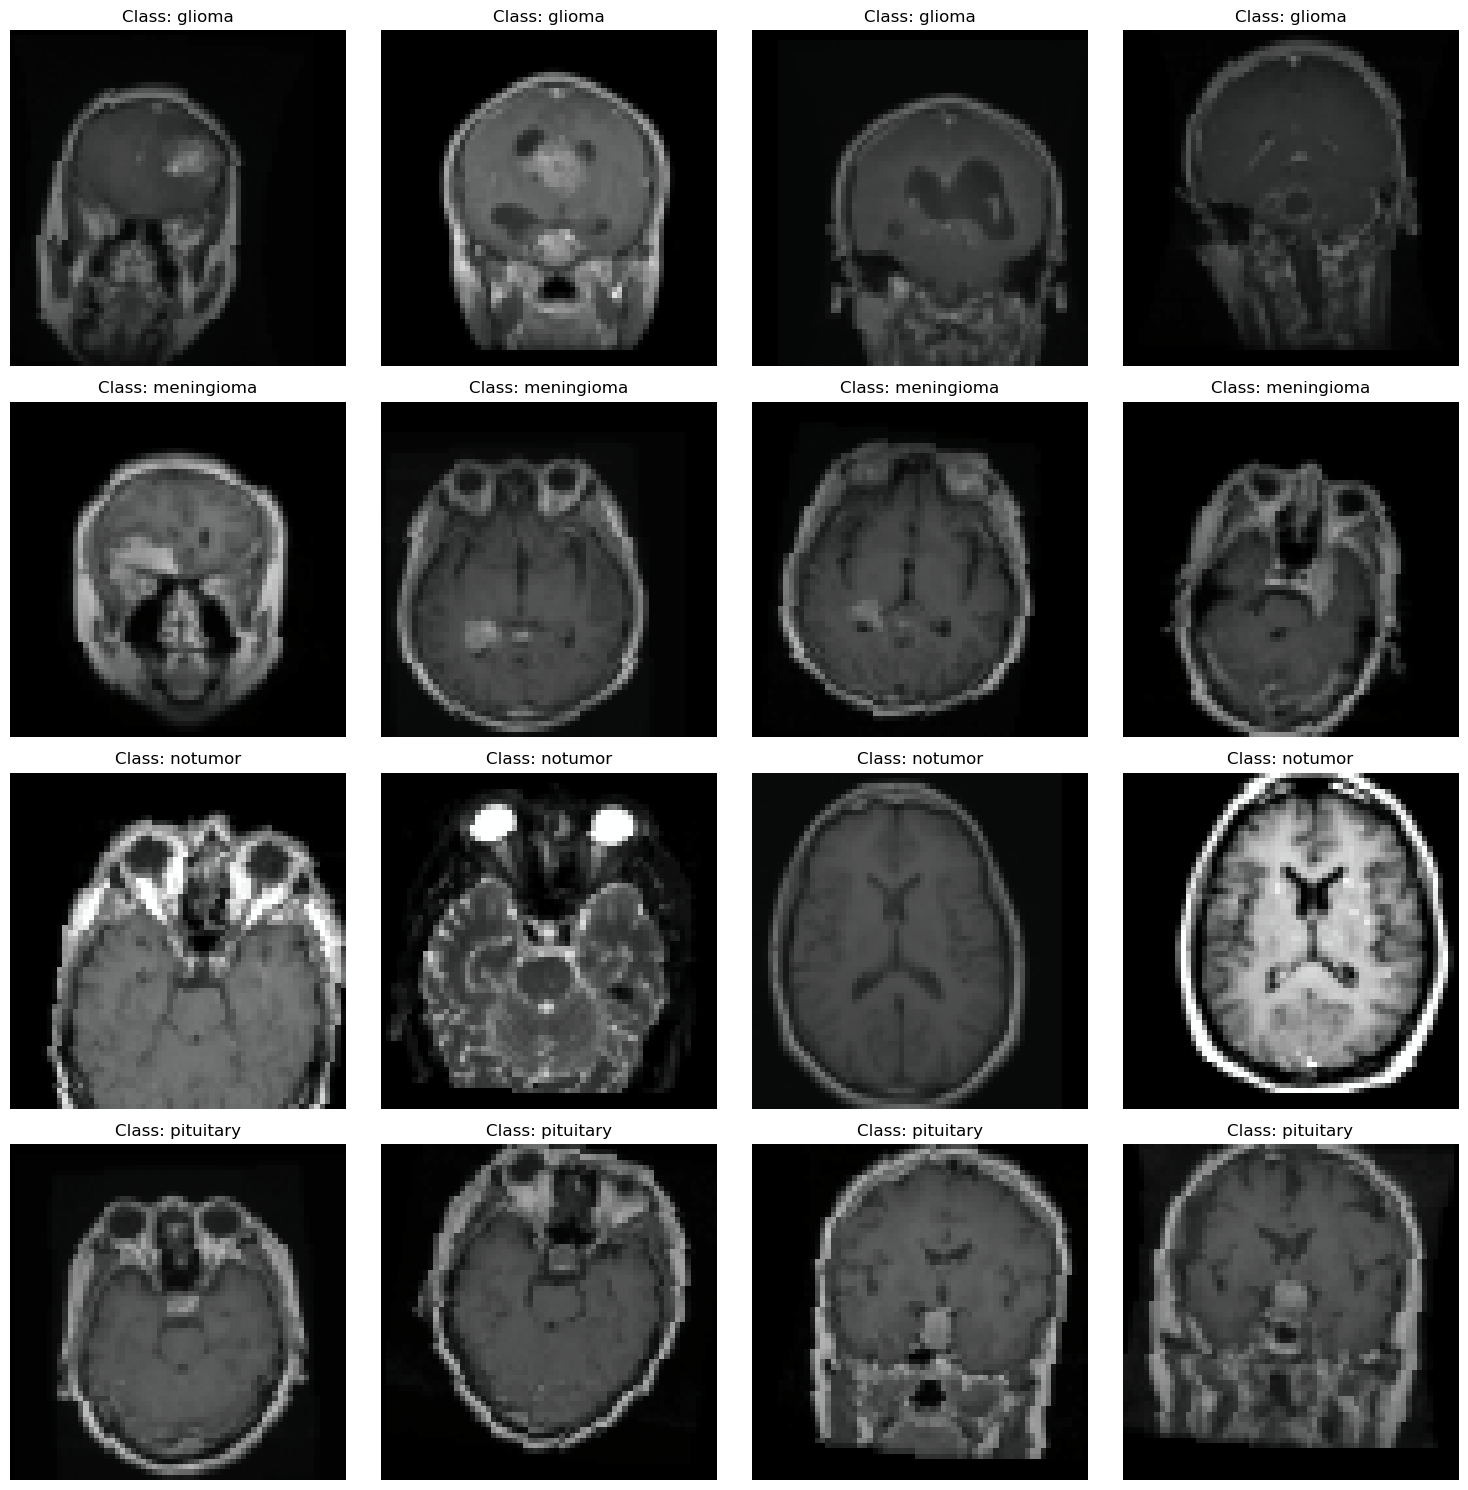

In [15]:
# Function to denormalize and convert tensor to numpy
def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.numpy().transpose((1, 2, 0))
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

# Initialize a dictionary to hold images for each class
class_images = {class_name: [] for class_name in train_dataset.classes}

# Iterate over the dataset and gather 4 images for each class
for image, label in train_dataset:
    class_name = train_dataset.classes[label]
    if len(class_images[class_name]) < 4:
        class_images[class_name].append(image)

# Plotting
fig, axs = plt.subplots(len(class_images), 4, figsize=(15, len(class_images) * 3.75))
for i, (class_name, images) in enumerate(class_images.items()):
    for j, image in enumerate(images):
        axs[i, j].imshow(denormalize(image))
        axs[i, j].set_title(f'Class: {class_name}')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


In [5]:
# Initialize numpy arrays for storing data and labels
data_all = np.zeros((num_images,) + image_shape, dtype=np.float32)
labels_all = np.zeros(num_images, dtype=np.int64)

# Iterate over the DataLoader and fill the arrays
start_idx = 0
for images, labels in train_loader:
    end_idx = start_idx + images.size(0)
    data_all[start_idx:end_idx] = images.numpy()
    labels_all[start_idx:end_idx] = labels.numpy()
    start_idx = end_idx
    
# Now data_all is a NumPy array containing all images
# and labels_all contains all corresponding labels
# {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

# Model Architecture

In [6]:
class BrainTumorClassifier(nn.Module):
    def __init__(self):
        super(BrainTumorClassifier, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate the size of the flattened output after conv and pooling layers
        # self.flattened_size = (64 // (2**3)) * (64 // (2**3)) * 128
        self.flattened_size = 8192
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, 4)
        
        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.softmax(self.fc2(x))
        
        return x

# skorch Wrapper (GridSearchCV)

In [24]:
# Wrap your model with skorch
net = NeuralNetClassifier(
    BrainTumorClassifier,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    batch_size=64,
    max_epochs=25,
    device=device,  # or 'cuda' if GPU is available
)

param_grid = {
    'lr': [0.0001, 0.001, 0.01, 0.005, 0.0005],
    'max_epochs': list(range(20, 55, 5))
    }

# Initialize lists to store data and labels
X_train = []
y_train = []

# Iterate over the DataLoader
for batch in train_loader:
    images, labels = batch

    # Move images and labels to CPU and convert them to NumPy
    images = images.numpy()
    labels = labels.numpy()

    # Append to lists
    X_train.append(images)
    y_train.append(labels)

# Concatenate all data and labels
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

In [25]:
grid = GridSearchCV(net, param_grid, refit=True, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

# Print the results
print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3206       0.5433        1.2281  1.3604
      2        1.1708       0.5932        1.1443  1.0985
      3        1.1205       0.6181        1.1267  1.0554
      4        1.1062       0.6339        1.1074  1.0629
      5        1.0924       0.6365        1.1056  1.0739
      6        1.0857       0.6430        1.0924  1.1369
      7        1.0799       0.6444        1.0889  1.0943
      8        1.0677       0.6654        1.0799  1.1391
      9        1.0590       0.6759        1.0735  1.1674
     10        1.0572       0.6601        1.0787  1.0674
     11        1.0485       0.6706        1.0700  1.0965
     12        1.0420       0.6719        1.0687  1.0593
     13        1.0339       0.6864        1.0604  1.0668
     14        1.0297       0.7021        1.0506  1.0590
     15        1.0167       0.6955        1.0453  1.0565
     16        1.0155       0.7

     13        1.0137       0.7218        1.0281  1.0960
     14        1.0028       0.7297        1.0164  1.0654
     15        0.9967       0.7283        1.0141  1.0619
     16        0.9957       0.7283        1.0133  1.0743
     17        0.9876       0.7297        1.0103  1.0657
     18        0.9893       0.7283        1.0126  1.0542
     19        0.9817       0.7428        1.0043  1.0580
     20        0.9739       0.7283        1.0147  1.0726
     21        0.9693       0.7467        0.9951  1.0697
     22        0.9694       0.7283        1.0094  1.0971
     23        0.9642       0.7349        0.9992  1.1269
     24        0.9589       0.7270        1.0130  1.1137
     25        0.9602       0.7336        1.0040  1.0762
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3114       0.5459        1.2144  1.0890
      2        1.1684       0.6076        1.1329  1.0661
      3        1.1193       0.6

      3        1.1210       0.6391        1.1071  1.0666
      4        1.1003       0.6247        1.1109  1.0634
      5        1.0895       0.6601        1.0848  1.0703
      6        1.0777       0.6654        1.0797  1.0638
      7        1.0716       0.6483        1.0807  1.0654
      8        1.0599       0.6732        1.0663  1.0752
      9        1.0509       0.6837        1.0600  1.0606
     10        1.0455       0.6903        1.0524  1.0722
     11        1.0415       0.6864        1.0538  1.0722
     12        1.0343       0.6929        1.0495  1.0712
     13        1.0295       0.6785        1.0539  1.0845
     14        1.0193       0.6811        1.0489  1.0692
     15        1.0184       0.6890        1.0412  1.0643
     16        1.0087       0.6916        1.0427  1.0591
     17        1.0061       0.7113        1.0248  1.0605
     18        1.0029       0.7073        1.0290  1.0737
     19        0.9978       0.7073        1.0273  1.0649
     20        0.9906       0.7

      7        1.0697       0.6509        1.0830  1.0504
      8        1.0605       0.6575        1.0754  1.0504
      9        1.0561       0.6562        1.0726  1.0519
     10        1.0454       0.6955        1.0580  1.0864
     11        1.0360       0.6772        1.0580  1.0512
     12        1.0313       0.6824        1.0560  1.0980
     13        1.0249       0.6890        1.0463  1.0576
     14        1.0183       0.6890        1.0460  1.0588
     15        1.0144       0.7087        1.0288  1.0577
     16        1.0061       0.6929        1.0427  1.0555
     17        0.9991       0.6995        1.0316  1.0577
     18        0.9927       0.7047        1.0286  1.0542
     19        0.9878       0.7231        1.0160  1.0665
     20        0.9841       0.7231        1.0141  1.0574
     21        0.9777       0.7244        1.0118  1.0609
     22        0.9734       0.7362        1.0021  1.1419
     23        0.9706       0.7428        0.9971  1.0596
     24        0.9644       0.7

     39        0.9184       0.7769        0.9646  1.0520
     40        0.9095       0.7782        0.9674  1.0524
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3271       0.5577        1.2283  1.0669
      2        1.1759       0.6089        1.1317  1.0573
      3        1.1199       0.6299        1.1024  1.0527
      4        1.0976       0.6378        1.0971  1.0513
      5        1.0844       0.6562        1.0806  1.0500
      6        1.0713       0.6588        1.0756  1.0532
      7        1.0655       0.6509        1.0803  1.0804
      8        1.0613       0.6759        1.0656  1.0571
      9        1.0530       0.6693        1.0679  1.0666
     10        1.0441       0.6588        1.0667  1.0546
     11        1.0360       0.6811        1.0553  1.0644
     12        1.0304       0.6969        1.0408  1.0581
     13        1.0241       0.6811        1.0501  1.0518
     14        1.0179       0.6

     19        0.9865       0.7205        1.0187  1.0547
     20        0.9831       0.7402        1.0037  1.1175
     21        0.9746       0.7415        0.9994  1.0531
     22        0.9731       0.7297        1.0057  1.0598
     23        0.9675       0.7336        1.0053  1.0946
     24        0.9627       0.7362        1.0043  1.0559
     25        0.9630       0.7336        1.0054  1.0546
     26        0.9610       0.7257        1.0088  1.0542
     27        0.9608       0.7493        0.9894  1.0569
     28        0.9490       0.7559        0.9821  1.0523
     29        0.9496       0.7454        0.9940  1.0536
     30        0.9449       0.7638        0.9800  1.0680
     31        0.9408       0.7388        1.0031  1.0599
     32        0.9393       0.7690        0.9762  1.0514
     33        0.9374       0.7546        0.9868  1.0530
     34        0.9371       0.7756        0.9740  1.0689
     35        0.9334       0.7598        0.9829  1.0578
     36        0.9271       0.7

     37        0.9295       0.7585        0.9857  1.0510
     38        0.9290       0.7585        0.9846  1.0508
     39        0.9269       0.7572        0.9842  1.0791
     40        0.9256       0.7480        0.9836  1.0588
     41        0.9203       0.7533        0.9799  1.0584
     42        0.9192       0.7598        0.9823  1.0878
     43        0.9180       0.7559        0.9810  1.0570
     44        0.9157       0.7598        0.9795  1.0542
     45        0.9144       0.7612        0.9794  1.0986
     46        0.9115       0.7598        0.9801  1.0565
     47        0.9064       0.7546        0.9835  1.0546
     48        0.9070       0.7598        0.9791  1.0553
     49        0.9031       0.7703        0.9783  1.0567
     50        0.9102       0.7625        0.9814  1.0550
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3254       0.5538        1.2260  1.0588
      2        1.1837       0.5

     45        0.9013       0.7559        0.9776  1.0538
     46        0.9051       0.7612        0.9751  1.0487
     47        0.9068       0.7730        0.9669  1.0448
     48        0.8953       0.7769        0.9675  1.0541
     49        0.8966       0.7769        0.9656  1.0497
     50        0.9009       0.7756        0.9691  1.0618
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2514       0.5446        1.1923  1.0459
      2        1.1579       0.5564        1.1799  1.0430
      3        1.1150       0.6365        1.1063  1.0496
      4        1.0963       0.6798        1.0637  1.0811
      5        1.0566       0.6549        1.0733  1.0491
      6        1.0436       0.6837        1.0615  1.0505
      7        1.0139       0.6837        1.0566  1.0998
      8        1.0012       0.7126        1.0328  1.0478
      9        0.9938       0.7087        1.0326  1.0470
     10        0.9761       0.6

     10        0.9516       0.7743        0.9682  1.0465
     11        0.9441       0.7625        0.9811  1.0462
     12        0.9276       0.7782        0.9667  1.0455
     13        0.9303       0.7585        0.9825  1.0587
     14        0.9142       0.7822        0.9606  1.0461
     15        0.9150       0.7940        0.9511  1.0940
     16        0.9280       0.7441        0.9936  1.0469
     17        0.8892       0.7953        0.9426  1.0478
     18        0.8764       0.7900        0.9518  1.0477
     19        0.8698       0.7782        0.9591  1.0697
     20        0.8629       0.7927        0.9441  1.0485
     21        0.8503       0.7992        0.9373  1.0487
     22        0.8578       0.7979        0.9387  1.0482
     23        0.8380       0.7966        0.9409  1.0486
     24        0.8393       0.8031        0.9414  1.0480
     25        0.8308       0.8005        0.9367  1.0499
  epoch    train_loss    valid_acc    valid_loss        dur
-------  ------------  -----

      4        1.0354       0.6982        1.0355  1.0464
      5        1.0084       0.7152        1.0196  1.0462
      6        0.9927       0.7283        1.0078  1.0468
      7        0.9829       0.7113        1.0280  1.0751
      8        0.9823       0.7559        0.9807  1.0475
      9        0.9537       0.7690        0.9760  1.0445
     10        0.9529       0.7664        0.9712  1.0450
     11        0.9288       0.7651        0.9728  1.0461
     12        0.9222       0.7887        0.9534  1.0453
     13        0.9077       0.7966        0.9473  1.0529
     14        0.8998       0.8176        0.9286  1.0489
     15        0.8796       0.8228        0.9200  1.0458
     16        0.8682       0.8084        0.9318  1.1199
     17        0.8592       0.8136        0.9279  1.0496
     18        0.8488       0.8110        0.9289  573.6420
     19        0.8414       0.8097        0.9324  1.0590
     20        0.8400       0.8255        0.9213  1.2339
     21        0.8307       0

     11        0.9232       0.7887        0.9564  1.2149
     12        0.9184       0.7953        0.9498  1.1160
     13        0.9019       0.7927        0.9491  1.0521
     14        0.8945       0.7913        0.9527  1.0510
     15        0.8800       0.7992        0.9377  1.0475
     16        0.8637       0.8005        0.9357  1.0519
     17        0.8601       0.8150        0.9242  1.0850
     18        0.8461       0.8228        0.9225  1.0467
     19        0.8450       0.8084        0.9251  1.0471
     20        0.8409       0.8189        0.9217  1.0484
     21        0.8347       0.8320        0.9099  1.0482
     22        0.8266       0.8150        0.9177  1.0488
     23        0.8324       0.8320        0.9115  1.0474
     24        0.8216       0.8084        0.9307  1.0578
     25        0.8217       0.8136        0.9206  1.0453
     26        0.8119       0.8228        0.9132  1.0907
     27        0.8163       0.8438        0.8954  1.0476
     28        0.8128       0.8

      5        1.0261       0.7008        1.0374  1.0488
      6        1.0052       0.7270        1.0089  1.0500
      7        0.9820       0.7336        1.0102  1.0485
      8        0.9705       0.7349        0.9980  1.2104
      9        0.9710       0.7467        0.9928  1.0961
     10        0.9475       0.7375        0.9953  1.0509
     11        0.9460       0.7703        0.9763  1.0476
     12        0.9355       0.7795        0.9624  1.0480
     13        0.9172       0.7730        0.9704  1.0495
     14        0.9099       0.7743        0.9655  1.0706
     15        0.8947       0.7966        0.9477  1.0485
     16        0.8849       0.7861        0.9495  1.0478
     17        0.8776       0.7822        0.9549  1.0464
     18        0.8682       0.7585        0.9775  1.0472
     19        0.8690       0.7913        0.9470  1.0467
     20        0.8585       0.7927        0.9476  1.0471
     21        0.8411       0.7992        0.9397  1.0584
     22        0.8414       0.7

     31        0.8343       0.8150        0.9271  1.0503
     32        0.8276       0.8228        0.9207  1.0479
     33        0.8286       0.8241        0.9177  1.0476
     34        0.8243       0.8228        0.9243  1.0489
     35        0.8349       0.8045        0.9382  1.1778
     36        0.8190       0.8281        0.9169  1.0559
     37        0.8150       0.8294        0.9126  1.1675
     38        0.8087       0.8228        0.9203  1.0515
     39        0.8074       0.8294        0.9157  1.0479
     40        0.8105       0.8346        0.9099  1.0477
     41        0.8053       0.8281        0.9113  1.0921
     42        0.8041       0.8110        0.9280  1.0482
     43        0.7968       0.8268        0.9175  1.0493
     44        0.7970       0.8346        0.9084  1.0478
     45        0.7972       0.8294        0.9117  1.0472
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3328       0.4

      3        1.0953       0.6575        1.0741  1.0792
      4        1.0652       0.6745        1.0658  1.2014
      5        1.0350       0.7034        1.0342  1.0850
      6        1.0170       0.6969        1.0393  1.0494
      7        1.0013       0.7192        1.0193  1.0456
      8        0.9831       0.7336        1.0055  1.0496
      9        0.9677       0.7572        0.9949  1.0801
     10        0.9608       0.7507        0.9875  1.1649
     11        0.9546       0.7139        1.0254  1.2235
     12        0.9476       0.7362        1.0004  1.3513
     13        0.9267       0.7664        0.9701  1.3769
     14        0.9374       0.7664        0.9739  1.2457
     15        0.9229       0.7913        0.9522  1.1449
     16        0.9022       0.7743        0.9625  1.0735
     17        0.8935       0.7966        0.9491  1.0472
     18        0.8872       0.7703        0.9632  1.0891
     19        0.8780       0.7927        0.9435  1.0474
     20        0.8711       0.7

     20        1.5093       0.2349        1.5088  1.5189
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5116       0.2349        1.5088  1.2846
      2        1.5093       0.2349        1.5088  1.1787
      3        1.5093       0.2349        1.5088  1.0822
      4        1.5093       0.2349        1.5088  1.0462
      5        1.5093       0.2349        1.5088  1.0452
      6        1.5093       0.2349        1.5088  1.0507
      7        1.5093       0.2349        1.5088  1.0812
      8        1.5093       0.2349        1.5088  1.1565
      9        1.5093       0.2349        1.5088  1.2961
     10        1.5093       0.2349        1.5088  1.4976
     11        1.5093       0.2349        1.5088  1.4983
     12        1.5093       0.2349        1.5088  1.2748
     13        1.5093       0.2349        1.5088  1.1712
     14        1.5093       0.2349        1.5088  1.1103
     15        1.5093       0.2

     14        1.5093       0.2349        1.5088  1.6768
     15        1.5093       0.2349        1.5088  1.4343
     16        1.5093       0.2349        1.5088  1.2243
     17        1.5093       0.2349        1.5088  1.2581
     18        1.5093       0.2349        1.5088  1.0590
     19        1.5093       0.2349        1.5088  1.0484
     20        1.5093       0.2349        1.5088  1.0802
     21        1.5093       0.2349        1.5088  1.0748
     22        1.5093       0.2349        1.5088  1.1550
     23        1.5093       0.2349        1.5088  1.3256
     24        1.5093       0.2349        1.5088  1.7041
     25        1.5093       0.2349        1.5088  1.6166
     26        1.5093       0.2349        1.5088  1.2840
     27        1.5093       0.2349        1.5088  1.1477
     28        1.5093       0.2349        1.5088  1.0709
     29        1.5093       0.2349        1.5088  1.0462
     30        1.5093       0.2349        1.5088  1.0462
  epoch    train_loss    valid_

     22        1.4886       0.2546        1.4891  1.1101
     23        1.4886       0.2546        1.4891  1.1288
     24        1.4886       0.2546        1.4891  1.1524
     25        1.4886       0.2546        1.4891  1.2044
     26        1.4886       0.2546        1.4891  1.2810
     27        1.4886       0.2546        1.4891  1.3741
     28        1.4886       0.2546        1.4891  1.3848
     29        1.4886       0.2546        1.4891  1.2938
     30        1.4886       0.2546        1.4891  1.2232
     31        1.4886       0.2546        1.4891  1.1686
     32        1.4886       0.2546        1.4891  1.1309
     33        1.4886       0.2546        1.4891  1.1195
     34        1.4886       0.2546        1.4891  1.1281
     35        1.4886       0.2546        1.4891  1.1632
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4886       0.2559        1.4878  1.2463
      2        1.4886       0.2

      5        1.5093       0.2336        1.5101  1.2093
      6        1.5093       0.2336        1.5101  1.2588
      7        1.5093       0.2336        1.5101  1.3358
      8        1.5093       0.2336        1.5101  1.3758
      9        1.5093       0.2336        1.5101  1.3142
     10        1.5093       0.2336        1.5101  1.2871
     11        1.5093       0.2336        1.5101  1.2263
     12        1.5093       0.2336        1.5101  1.1987
     13        1.5093       0.2336        1.5101  1.1773
     14        1.5093       0.2336        1.5101  1.1735
     15        1.5093       0.2336        1.5101  1.1885
     16        1.5093       0.2336        1.5101  1.1943
     17        1.5093       0.2336        1.5101  1.2234
     18        1.5093       0.2336        1.5101  1.2539
     19        1.5093       0.2336        1.5101  1.2922
     20        1.5093       0.2336        1.5101  1.2948
     21        1.5093       0.2336        1.5101  1.2806
     22        1.5093       0.2

     11        1.5093       0.2336        1.5101  1.3014
     12        1.5093       0.2336        1.5101  1.2549
     13        1.5093       0.2336        1.5101  1.2273
     14        1.5093       0.2336        1.5101  1.2077
     15        1.5093       0.2336        1.5101  1.2098
     16        1.5093       0.2336        1.5101  1.2290
     17        1.5093       0.2336        1.5101  1.2511
     18        1.5093       0.2336        1.5101  1.2865
     19        1.5093       0.2336        1.5101  1.3557
     20        1.5093       0.2336        1.5101  1.3406
     21        1.5093       0.2336        1.5101  1.3371
     22        1.5093       0.2336        1.5101  1.2859
     23        1.5093       0.2336        1.5101  1.2635
     24        1.5093       0.2336        1.5101  1.2432
     25        1.5093       0.2336        1.5101  1.2223
     26        1.5093       0.2336        1.5101  1.2111
     27        1.5093       0.2336        1.5101  1.2073
     28        1.5093       0.2

      2        1.5093       0.2336        1.5101  1.2180
      3        1.5093       0.2336        1.5101  1.4365
      4        1.5093       0.2336        1.5101  1.2337
      5        1.5093       0.2336        1.5101  1.2449
      6        1.5093       0.2336        1.5101  1.2776
      7        1.5093       0.2336        1.5101  1.2659
      8        1.5093       0.2336        1.5101  1.2670
      9        1.5093       0.2336        1.5101  1.2639
     10        1.5093       0.2336        1.5101  1.2545
     11        1.5093       0.2336        1.5101  1.2462
     12        1.5093       0.2336        1.5101  1.2415
     13        1.5093       0.2336        1.5101  1.2394
     14        1.5093       0.2336        1.5101  1.2754
     15        1.5093       0.2336        1.5101  1.2821
     16        1.5093       0.2336        1.5101  1.3471
     17        1.5093       0.2336        1.5101  1.4203
     18        1.5093       0.2336        1.5101  1.3824
     19        1.5093       0.2

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5124       0.2349        1.5088  1.2667
      2        1.5093       0.2349        1.5088  1.2610
      3        1.5093       0.2349        1.5088  1.2931
      4        1.5093       0.2349        1.5088  1.2635
      5        1.5093       0.2349        1.5088  1.2867
      6        1.5093       0.2349        1.5088  1.3093
      7        1.5093       0.2349        1.5088  1.3005
      8        1.5093       0.2349        1.5088  1.2908
      9        1.5093       0.2349        1.5088  1.2769
     10        1.5093       0.2349        1.5088  1.2726
     11        1.5093       0.2349        1.5088  1.2702
     12        1.5093       0.2349        1.5088  1.2699
     13        1.5093       0.2349        1.5088  1.2717
     14        1.5093       0.2349        1.5088  1.2729
     15        1.5093       0.2349        1.5088  1.2907
     16        1.5093       0.2

     22        1.5093       0.2336        1.5101  1.4182
     23        1.5093       0.2336        1.5101  1.4322
     24        1.5089       0.2336        1.5101  1.4699
     25        1.5093       0.2336        1.5101  1.4380
     26        1.5093       0.2336        1.5101  1.4187
     27        1.5093       0.2336        1.5101  1.4085
     28        1.5093       0.2336        1.5101  1.4033
     29        1.5093       0.2336        1.5101  1.3909
     30        1.5093       0.2336        1.5101  1.3827
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5146       0.2349        1.5088  1.4151
      2        1.5093       0.2349        1.5088  1.3934
      3        1.5093       0.2349        1.5088  1.4675
      4        1.5093       0.2349        1.5088  1.4783
      5        1.5093       0.2349        1.5088  1.4972
      6        1.5093       0.2349        1.5088  1.4648
      7        1.5093       0.2

     21        1.5093       0.2349        1.5088  1.6053
     22        1.5093       0.2349        1.5088  1.5929
     23        1.5093       0.2349        1.5088  1.5456
     24        1.5093       0.2349        1.5088  1.5101
     25        1.5093       0.2349        1.5088  1.5172
     26        1.5093       0.2349        1.5088  1.5370
     27        1.5093       0.2349        1.5088  1.5474
     28        1.5093       0.2349        1.5088  1.5515
     29        1.5093       0.2349        1.5088  1.5661
     30        1.5093       0.2349        1.5088  1.5990
     31        1.5093       0.2349        1.5088  1.5843
     32        1.5093       0.2349        1.5088  1.5410
     33        1.5093       0.2349        1.5088  1.4989
     34        1.5093       0.2349        1.5088  1.4876
     35        1.5093       0.2349        1.5088  1.4964
     36        1.5093       0.2349        1.5088  1.5463
     37        1.5093       0.2349        1.5088  1.5668
     38        1.5093       0.2

     37        1.5093       0.2349        1.5088  1.4702
     38        1.5093       0.2349        1.5088  1.4623
     39        1.5093       0.2349        1.5088  1.4823
     40        1.5093       0.2349        1.5088  1.5114
     41        1.5093       0.2349        1.5088  1.5451
     42        1.5093       0.2349        1.5088  1.5712
     43        1.5093       0.2349        1.5088  1.5387
     44        1.5093       0.2349        1.5088  1.5625
     45        1.5093       0.2349        1.5088  1.5740
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4897       0.2546        1.4891  1.5054
      2        1.4886       0.2546        1.4891  1.4935
      3        1.4886       0.2546        1.4891  1.4897
      4        1.4886       0.2546        1.4891  1.5136
      5        1.4886       0.2546        1.4891  1.5352
      6        1.4886       0.2546        1.4891  1.5605
      7        1.4886       0.2

     37        1.5093       0.2349        1.5088  1.4979
     38        1.5093       0.2349        1.5088  1.5221
     39        1.5093       0.2349        1.5088  1.5680
     40        1.5093       0.2349        1.5088  1.6186
     41        1.5093       0.2349        1.5088  1.6654
     42        1.5093       0.2349        1.5088  1.6258
     43        1.5093       0.2349        1.5088  1.6387
     44        1.5093       0.2349        1.5088  1.5978
     45        1.5093       0.2349        1.5088  1.5524
     46        1.5093       0.2349        1.5088  1.5396
     47        1.5093       0.2349        1.5088  1.5663
     48        1.5093       0.2349        1.5088  1.6220
     49        1.5093       0.2349        1.5088  1.6327
     50        1.5093       0.2349        1.5088  1.6821
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5111       0.2349        1.5088  1.6457
      2        1.5093       0.2

     17        0.8870       0.7664        0.9768  1.7109
     18        0.8893       0.7795        0.9567  1.6439
     19        0.8829       0.7861        0.9526  1.6198
     20        0.8675       0.7874        0.9467  1.6017
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2402       0.6024        1.1313  1.5787
      2        1.1176       0.6430        1.0916  1.5924
      3        1.0742       0.6772        1.0621  1.6605
      4        1.0502       0.6982        1.0374  1.7144
      5        1.0410       0.6955        1.0413  1.7229
      6        1.0201       0.7152        1.0279  1.7232
      7        1.0034       0.7034        1.0351  1.7347
      8        0.9939       0.7205        1.0293  1.6824
      9        0.9825       0.7507        0.9944  1.6070
     10        0.9655       0.7651        0.9851  1.5835
     11        0.9433       0.7638        0.9773  1.5988
     12        0.9346       0.7

      6        1.0136       0.6772        1.0508  1.6589
      7        0.9960       0.7441        1.0010  1.6357
      8        0.9807       0.7362        1.0008  1.6459
      9        0.9686       0.7428        0.9912  1.6754
     10        0.9603       0.7441        0.9898  1.6913
     11        0.9525       0.7677        0.9762  1.7112
     12        0.9357       0.7690        0.9748  1.7297
     13        0.9285       0.7782        0.9590  1.7392
     14        0.9216       0.7730        0.9679  1.7223
     15        0.9037       0.7835        0.9654  1.6825
     16        0.9006       0.7900        0.9552  1.6565
     17        0.8826       0.8071        0.9408  1.6533
     18        0.8865       0.8031        0.9419  1.6684
     19        0.8715       0.8045        0.9354  1.6890
     20        0.8686       0.8228        0.9223  1.7418
     21        0.8566       0.8176        0.9233  1.8544
     22        0.8562       0.8202        0.9245  1.8574
     23        0.8557       0.8

     25        0.8241       0.8241        0.9162  1.7192
     26        0.8201       0.8176        0.9246  1.6862
     27        0.8234       0.8255        0.9206  1.6815
     28        0.8174       0.8176        0.9252  1.6607
     29        0.8137       0.8255        0.9122  1.6926
     30        0.8196       0.8281        0.9126  1.6983
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2708       0.5079        1.2323  1.6281
      2        1.1416       0.6404        1.1003  1.6126
      3        1.1079       0.6391        1.0937  1.6107
      4        1.0704       0.6325        1.1058  1.6345
      5        1.0581       0.6640        1.0711  1.6558
      6        1.0368       0.6837        1.0516  1.6960
      7        1.0128       0.6929        1.0433  1.6963
      8        0.9982       0.7152        1.0246  1.7387
      9        0.9916       0.7060        1.0378  1.7180
     10        0.9824       0.7

     31        0.8150       0.8241        0.9149  1.7802
     32        0.8134       0.8189        0.9230  1.8316
     33        0.8114       0.8281        0.9169  1.8648
     34        0.8058       0.8189        0.9203  1.8003
     35        0.8100       0.8255        0.9178  1.7114
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2570       0.5643        1.1600  1.6503
      2        1.1310       0.6220        1.1188  1.6757
      3        1.1023       0.6430        1.0967  1.7338
      4        1.0731       0.6535        1.0767  1.8017
      5        1.0545       0.6837        1.0514  1.8603
      6        1.0327       0.7034        1.0376  1.8145
      7        1.0130       0.7113        1.0266  1.7039
      8        0.9940       0.7113        1.0271  1.6452
      9        0.9797       0.6929        1.0438  1.6502
     10        0.9712       0.7060        1.0320  1.6882
     11        0.9634       0.7

     22        0.8827       0.7900        0.9522  1.6962
     23        0.8873       0.7992        0.9407  1.6999
     24        0.8706       0.8018        0.9397  1.6953
     25        0.8691       0.8097        0.9379  1.7005
     26        0.8763       0.7966        0.9437  1.6520
     27        0.8640       0.8150        0.9243  1.7071
     28        0.8570       0.8031        0.9347  1.7495
     29        0.8546       0.8097        0.9339  1.7726
     30        0.8542       0.8005        0.9425  1.7574
     31        0.8421       0.8097        0.9367  1.7987
     32        0.8382       0.8150        0.9288  1.7351
     33        0.8330       0.8228        0.9197  1.6763
     34        0.8297       0.8202        0.9263  1.6353
     35        0.8303       0.8268        0.9180  1.6985
     36        0.8244       0.8031        0.9360  1.7756
     37        0.8246       0.8084        0.9288  1.7634
     38        0.8247       0.8084        0.9331  1.8673
     39        0.8212       0.8

      3        1.0909       0.6667        1.0740  1.7487
      4        1.0515       0.6732        1.0602  1.7177
      5        1.0261       0.7034        1.0341  1.6782
      6        1.0058       0.7139        1.0218  1.6808
      7        0.9905       0.7218        1.0210  1.7005
      8        0.9789       0.7008        1.0312  1.7277
      9        0.9751       0.7441        0.9960  1.7451
     10        0.9508       0.7690        0.9764  1.8294
     11        0.9414       0.7756        0.9671  1.8509
     12        0.9366       0.7677        0.9674  1.7263
     13        0.9321       0.7822        0.9615  1.6528
     14        0.9188       0.7664        0.9737  1.6380
     15        0.9097       0.7795        0.9703  1.6863
     16        0.9039       0.7992        0.9479  1.7609
     17        0.8923       0.7900        0.9488  1.8468
     18        0.8882       0.8163        0.9344  1.9699
     19        0.8878       0.8084        0.9334  1.8588
     20        0.8750       0.7

     18        0.8697       0.8110        0.9359  2.0642
     19        0.8610       0.8255        0.9222  2.4000
     20        0.8549       0.8255        0.9234  2.2352
     21        0.8589       0.7966        0.9462  1.9068
     22        0.8377       0.8163        0.9291  1.7620
     23        0.8452       0.8058        0.9336  1.7954
     24        0.8315       0.8163        0.9233  2.0107
     25        0.8324       0.8163        0.9222  2.3428
     26        0.8219       0.8136        0.9251  2.6968
     27        0.8215       0.8136        0.9257  2.3620
     28        0.8212       0.8097        0.9249  1.8086
     29        0.8188       0.8045        0.9406  1.6912
     30        0.8136       0.8307        0.9136  1.8381
     31        0.8108       0.8150        0.9263  2.1725
     32        0.8071       0.8255        0.9199  2.3446
     33        0.8058       0.8268        0.9145  2.1157
     34        0.8007       0.8307        0.9186  1.9738
     35        0.8039       0.8

     33        0.7840       0.8635        0.8795  2.4672
     34        0.7870       0.8539        0.8858  2.4038
     35        0.7857       0.8451        0.8944  2.4945
     36        0.7883       0.8574        0.8866  2.5504
     37        0.7844       0.8591        0.8810  2.5450
     38        0.7834       0.8521        0.8870  2.5431
     39        0.7812       0.8583        0.8824  2.5030
     40        0.7800       0.8416        0.8967  2.4616
Best parameters: {'lr': 0.001, 'max_epochs': 40}
Best score: 0.8350840336134454


# Subset Testing

In [13]:
#Subset sampling
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

device = torch.device("mps")
num_epochs = 25
subset_size = 80

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
    print(f'Fold {fold+1}/{k_folds}')

    # Randomly sample indices for training and testing
    train_indices = np.random.choice(len(train_dataset), subset_size, replace=False)
    test_indices = np.random.choice(len(test_dataset), subset_size, replace=False)

    # Create samplers
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=64, sampler=test_sampler, num_workers=0)

    # Instantiate a new model for this fold
    model = BrainTumorClassifier()
    model.to(device)

    # Define the loss function and optimizer for this fold
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()  
    
    # Start the training loop for this fold
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_loss = running_loss / len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_loss = running_loss_val / len(test_loader)

        # Print statistics for this epoch
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    print(f'Finished Training for Fold {fold+1}')

Fold 1/5
Epoch 1/25, Train Loss: 1.3580, Train Accuracy: 30.00%, Val Loss: 1.5194, Val Accuracy: 15.00%
Epoch 2/25, Train Loss: 1.3734, Train Accuracy: 28.75%, Val Loss: 1.3652, Val Accuracy: 33.75%
Epoch 3/25, Train Loss: 1.2996, Train Accuracy: 45.00%, Val Loss: 1.3679, Val Accuracy: 30.00%
Epoch 4/25, Train Loss: 1.2344, Train Accuracy: 47.50%, Val Loss: 1.3767, Val Accuracy: 31.25%
Epoch 5/25, Train Loss: 1.2437, Train Accuracy: 47.50%, Val Loss: 1.2972, Val Accuracy: 35.00%
Epoch 6/25, Train Loss: 1.2183, Train Accuracy: 55.00%, Val Loss: 1.3207, Val Accuracy: 36.25%
Epoch 7/25, Train Loss: 1.2411, Train Accuracy: 50.00%, Val Loss: 1.3825, Val Accuracy: 32.50%
Epoch 8/25, Train Loss: 1.2625, Train Accuracy: 51.25%, Val Loss: 1.3470, Val Accuracy: 35.00%
Epoch 9/25, Train Loss: 1.2219, Train Accuracy: 45.00%, Val Loss: 1.3057, Val Accuracy: 36.25%
Epoch 10/25, Train Loss: 1.2700, Train Accuracy: 56.25%, Val Loss: 1.3218, Val Accuracy: 32.50%
Epoch 11/25, Train Loss: 1.1896, Train A

Epoch 11/25, Train Loss: 1.1888, Train Accuracy: 50.00%, Val Loss: 1.2442, Val Accuracy: 38.75%
Epoch 12/25, Train Loss: 1.1800, Train Accuracy: 45.00%, Val Loss: 1.2985, Val Accuracy: 43.75%
Epoch 13/25, Train Loss: 1.1378, Train Accuracy: 55.00%, Val Loss: 1.3238, Val Accuracy: 41.25%
Epoch 14/25, Train Loss: 1.1862, Train Accuracy: 56.25%, Val Loss: 1.2389, Val Accuracy: 46.25%
Epoch 15/25, Train Loss: 1.2039, Train Accuracy: 50.00%, Val Loss: 1.3197, Val Accuracy: 46.25%
Epoch 16/25, Train Loss: 1.2380, Train Accuracy: 43.75%, Val Loss: 1.2752, Val Accuracy: 50.00%
Epoch 17/25, Train Loss: 1.1252, Train Accuracy: 53.75%, Val Loss: 1.2364, Val Accuracy: 51.25%
Epoch 18/25, Train Loss: 1.1086, Train Accuracy: 62.50%, Val Loss: 1.2702, Val Accuracy: 50.00%
Epoch 19/25, Train Loss: 1.1110, Train Accuracy: 62.50%, Val Loss: 1.2409, Val Accuracy: 52.50%
Epoch 20/25, Train Loss: 1.2088, Train Accuracy: 61.25%, Val Loss: 1.2806, Val Accuracy: 51.25%
Epoch 21/25, Train Loss: 1.1280, Train A

# Full Training / Validation

In [16]:
#Full training / Validation
k_folds = 5
num_epochs = 40
device = 'mps'

# Initialize lists to store metrics
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for fold in range(k_folds):
    print(f'Fold {fold+1}/{k_folds}')

    # Create data loaders for the entire datasets
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

    # Instantiate a new model for this fold
    model = BrainTumorClassifier()
    model.to(device)

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()  

    # Training and validation loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_loss = running_loss_val / len(test_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)


        # Print statistics for this epoch
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    print(f'Finished Training for Fold {fold+1}')

Fold 1/5
Epoch 1/40, Train Loss: 1.1927, Train Accuracy: 53.45%, Val Loss: 1.1059, Val Accuracy: 62.70%
Epoch 2/40, Train Loss: 1.0892, Train Accuracy: 64.58%, Val Loss: 1.1025, Val Accuracy: 61.56%
Epoch 3/40, Train Loss: 1.0679, Train Accuracy: 66.96%, Val Loss: 1.0498, Val Accuracy: 68.27%
Epoch 4/40, Train Loss: 1.0339, Train Accuracy: 70.24%, Val Loss: 1.0041, Val Accuracy: 73.15%
Epoch 5/40, Train Loss: 1.0093, Train Accuracy: 72.51%, Val Loss: 0.9841, Val Accuracy: 75.29%
Epoch 6/40, Train Loss: 0.9806, Train Accuracy: 75.86%, Val Loss: 0.9941, Val Accuracy: 74.29%
Epoch 7/40, Train Loss: 0.9797, Train Accuracy: 76.03%, Val Loss: 0.9809, Val Accuracy: 75.44%
Epoch 8/40, Train Loss: 0.9783, Train Accuracy: 75.98%, Val Loss: 0.9926, Val Accuracy: 74.37%
Epoch 9/40, Train Loss: 0.9595, Train Accuracy: 78.27%, Val Loss: 0.9890, Val Accuracy: 74.83%
Epoch 10/40, Train Loss: 0.9503, Train Accuracy: 78.83%, Val Loss: 0.9510, Val Accuracy: 79.10%
Epoch 11/40, Train Loss: 0.9352, Train A

Epoch 6/40, Train Loss: 1.0149, Train Accuracy: 72.23%, Val Loss: 1.0063, Val Accuracy: 73.00%
Epoch 7/40, Train Loss: 0.9868, Train Accuracy: 75.07%, Val Loss: 0.9824, Val Accuracy: 75.36%
Epoch 8/40, Train Loss: 0.9749, Train Accuracy: 76.68%, Val Loss: 0.9847, Val Accuracy: 75.13%
Epoch 9/40, Train Loss: 0.9775, Train Accuracy: 76.07%, Val Loss: 0.9585, Val Accuracy: 77.80%
Epoch 10/40, Train Loss: 0.9522, Train Accuracy: 79.06%, Val Loss: 0.9602, Val Accuracy: 77.35%
Epoch 11/40, Train Loss: 0.9445, Train Accuracy: 79.83%, Val Loss: 1.0374, Val Accuracy: 68.95%
Epoch 12/40, Train Loss: 0.9354, Train Accuracy: 80.69%, Val Loss: 0.9308, Val Accuracy: 80.32%
Epoch 13/40, Train Loss: 0.9205, Train Accuracy: 82.30%, Val Loss: 0.9390, Val Accuracy: 79.63%
Epoch 14/40, Train Loss: 0.9139, Train Accuracy: 82.90%, Val Loss: 0.9399, Val Accuracy: 79.63%
Epoch 15/40, Train Loss: 0.9059, Train Accuracy: 83.63%, Val Loss: 0.9188, Val Accuracy: 81.39%
Epoch 16/40, Train Loss: 0.9146, Train Accur

Epoch 11/40, Train Loss: 0.9192, Train Accuracy: 82.42%, Val Loss: 0.9452, Val Accuracy: 78.95%
Epoch 12/40, Train Loss: 0.9278, Train Accuracy: 81.57%, Val Loss: 0.9110, Val Accuracy: 83.22%
Epoch 13/40, Train Loss: 0.9158, Train Accuracy: 82.60%, Val Loss: 0.9263, Val Accuracy: 80.93%
Epoch 14/40, Train Loss: 0.9011, Train Accuracy: 84.09%, Val Loss: 0.9407, Val Accuracy: 79.18%
Epoch 15/40, Train Loss: 0.8890, Train Accuracy: 85.24%, Val Loss: 0.9278, Val Accuracy: 80.93%
Epoch 16/40, Train Loss: 0.8907, Train Accuracy: 85.21%, Val Loss: 0.8895, Val Accuracy: 84.59%
Epoch 17/40, Train Loss: 0.8881, Train Accuracy: 85.38%, Val Loss: 0.9090, Val Accuracy: 83.07%
Epoch 18/40, Train Loss: 0.8822, Train Accuracy: 85.96%, Val Loss: 0.8955, Val Accuracy: 84.21%
Epoch 19/40, Train Loss: 0.8861, Train Accuracy: 85.47%, Val Loss: 0.9148, Val Accuracy: 82.23%
Epoch 20/40, Train Loss: 0.8739, Train Accuracy: 86.96%, Val Loss: 0.8790, Val Accuracy: 85.89%
Epoch 21/40, Train Loss: 0.8755, Train A

In [17]:
torch.save(model.state_dict(), '/Users/brockada/CS4100PROJ/final_model.pth')

# Final Model Evaluation

In [12]:
# Load the trained model
model = BrainTumorClassifier()
model.load_state_dict(torch.load('/Users/brockada/CS4100PROJ/final_model.pth'))
model.to(device)
model.eval()

# Initialize lists to store predictions and actual labels
predictions = []
actuals = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)

        # Convert outputs to predicted class (index with the highest score)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and actual labels
        predictions.extend(predicted.view(-1).tolist())
        actuals.extend(labels.view(-1).tolist())

# Calculate accuracy or other metrics as needed
accuracy = sum(np.array(predictions) == np.array(actuals)) / len(actuals)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8749


Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.78      0.87       300
  meningioma       0.81      0.73      0.77       306
     notumor       0.86      0.97      0.91       405
   pituitary       0.87      0.99      0.92       300

    accuracy                           0.87      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.87      0.87      1311

Accuracy: 0.8749



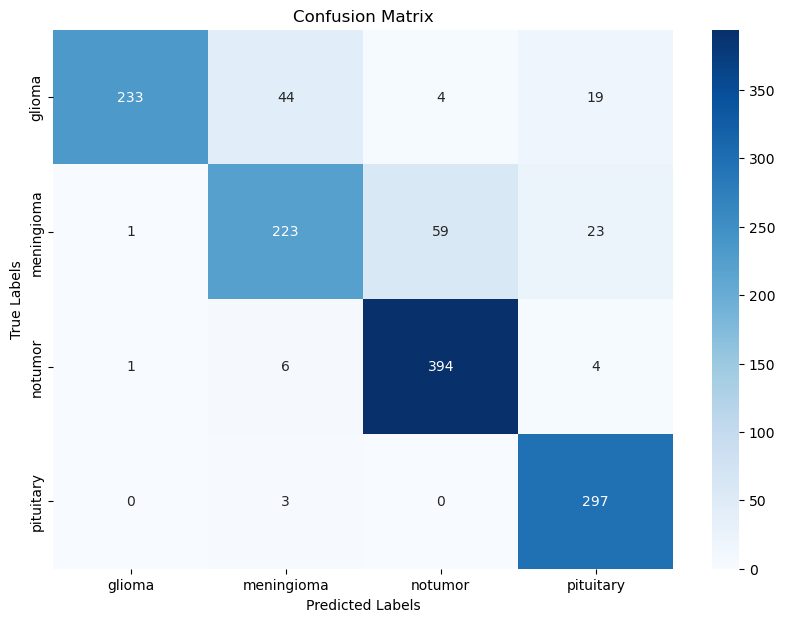

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the 'predictions' and 'actuals' lists from the previous step

# Calculate the confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)

# Calculate the classification report
class_report = classification_report(actuals, predictions, target_names=test_dataset.classes)

# Calculate accuracy
accuracy = accuracy_score(actuals, predictions)

# Print the classification report and accuracy
print("Classification Report:\n", class_report)
print(f"Accuracy: {accuracy:.4f}\n")

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

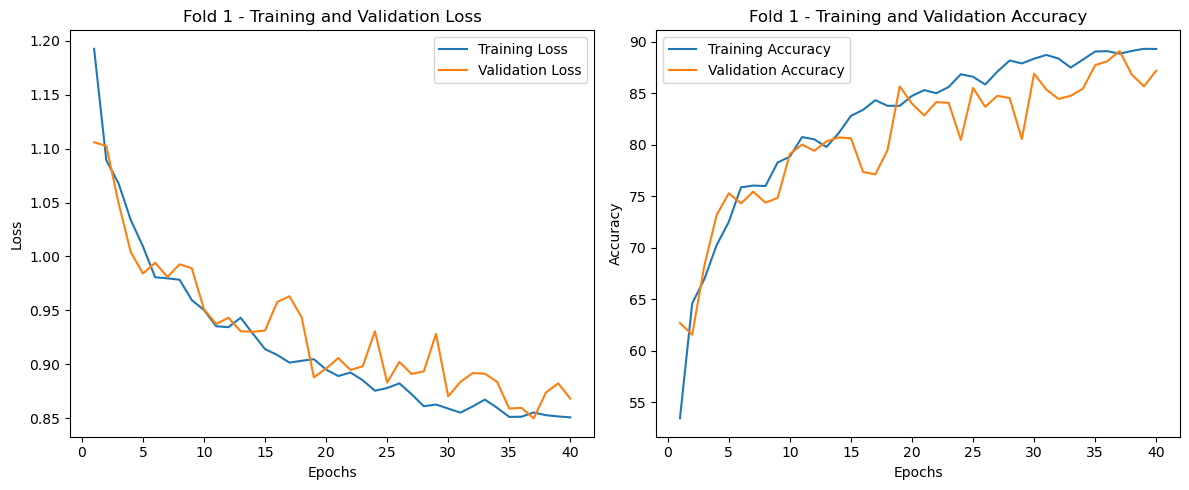

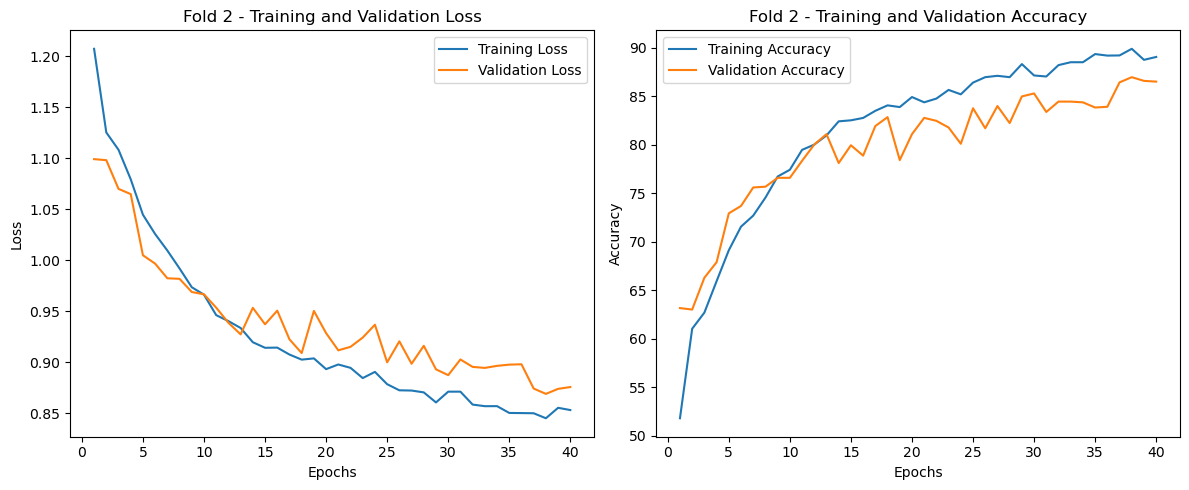

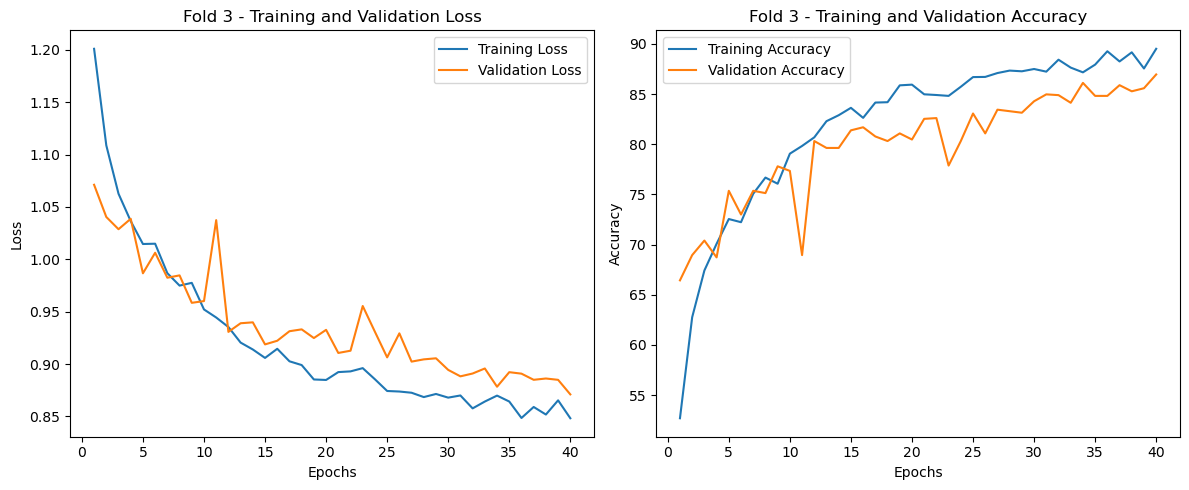

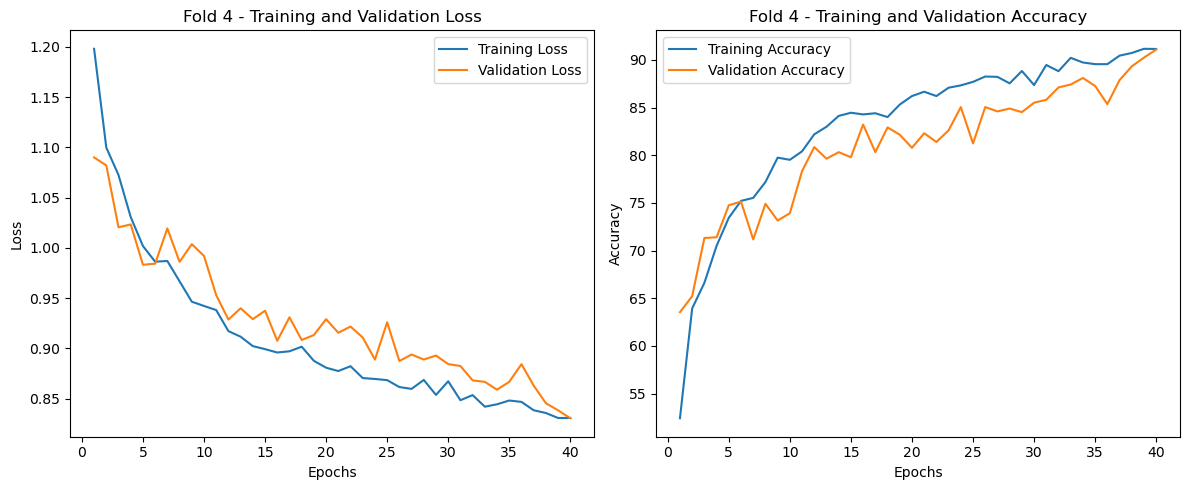

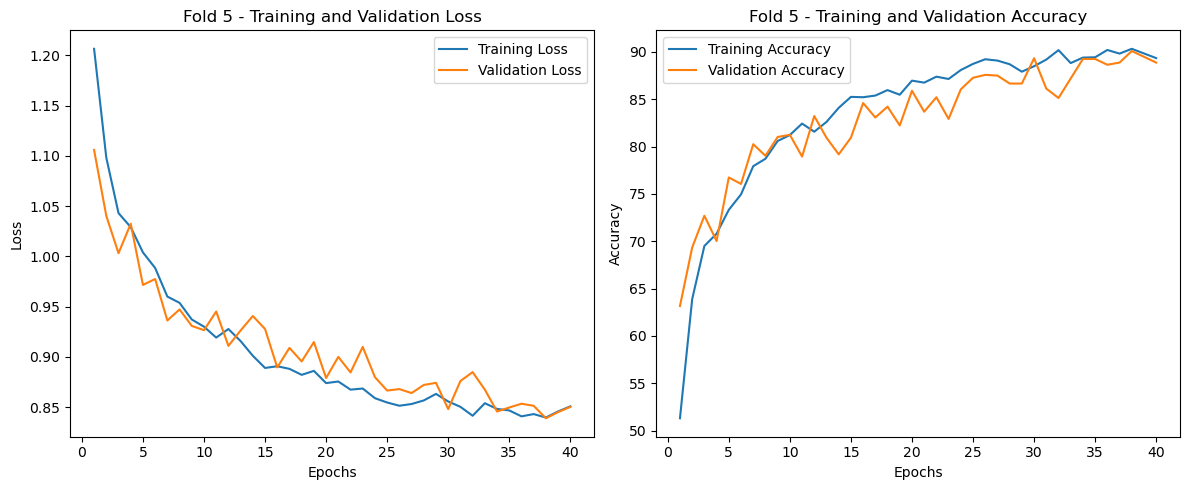

In [23]:
fold_size = num_epochs

# Plotting for each fold separately
for fold in range(k_folds):
    start_idx = fold * fold_size
    end_idx = start_idx + fold_size

    plt.figure(figsize=(12, 5))

    # Plotting training and validation loss for the current fold
    plt.subplot(1, 2, 1)
    plt.plot(range(1, fold_size + 1), train_losses[start_idx:end_idx], label='Training Loss')
    plt.plot(range(1, fold_size + 1), val_losses[start_idx:end_idx], label='Validation Loss')
    plt.title(f'Fold {fold + 1} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy for the current fold
    plt.subplot(1, 2, 2)
    plt.plot(range(1, fold_size + 1), train_accuracies[start_idx:end_idx], label='Training Accuracy')
    plt.plot(range(1, fold_size + 1), val_accuracies[start_idx:end_idx], label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
